In [4]:
!pip install ultralytics opencv-python-headless matplotlib scikit-learn tqdm --quiet

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
from ultralytics import YOLO
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
VIDEO_PATHS = {
    "broadcast": "/content/broadcast.mp4",
    "tacticam": "/content/tacticam.mp4"
}
OUTPUT_DIR = Path("output/detections")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
model = YOLO('yolov8m.pt')  # Person class = 0 in COCO

for cam_name, video_path in VIDEO_PATHS.items():
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    cam_output_dir = OUTPUT_DIR / cam_name
    cam_output_dir.mkdir(parents=True, exist_ok=True)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % 10 != 0:  # Skip frames for better runtime
            frame_idx += 1
            continue

        results = model(frame)[0]
        for i, box in enumerate(results.boxes):
            cls_id = int(box.cls[0].item())
            conf = float(box.conf[0].item())
            if cls_id == 0 and conf > 0.5:
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                crop = frame[y1:y2, x1:x2]
                crop_path = cam_output_dir / f"frame{frame_idx:04d}_player{i}.jpg"
                cv2.imwrite(str(crop_path), crop)

        frame_idx += 1
    cap.release()
    print(f"[{cam_name}] Done!")

100%|██████████| 49.7M/49.7M [00:00<00:00, 199MB/s]



0: 384x640 2 persons, 1 sports ball, 1108.0ms
Speed: 19.7ms preprocess, 1108.0ms inference, 30.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 909.3ms
Speed: 3.1ms preprocess, 909.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 928.8ms
Speed: 4.1ms preprocess, 928.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 942.1ms
Speed: 3.1ms preprocess, 942.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1374.4ms
Speed: 4.2ms preprocess, 1374.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1512.2ms
Speed: 3.9ms preprocess, 1512.2ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1001.6ms
Speed: 4.8ms preprocess, 1001.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 931.7ms
Speed: 4.7ms preprocess, 931.7ms in

In [8]:
def extract_histogram(image_path):
    img = cv2.imread(str(image_path))
    if img is None:
        return None
    img = cv2.resize(img, (64, 128))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [50, 60], [0, 180, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def load_features(folder_path):
    features = {}
    for img_file in Path(folder_path).glob("*.jpg"):
        hist = extract_histogram(img_file)
        if hist is not None:
            features[img_file.name] = hist
    return features

broadcast_feats = load_features(OUTPUT_DIR / "broadcast")
tacticam_feats = load_features(OUTPUT_DIR / "tacticam")

In [9]:
broadcast_keys = list(broadcast_feats.keys())
broadcast_vectors = np.array([broadcast_feats[k] for k in broadcast_keys])

tacticam_keys = list(tacticam_feats.keys())
tacticam_vectors = np.array([tacticam_feats[k] for k in tacticam_keys])

similarity = cosine_similarity(broadcast_vectors, tacticam_vectors)

matches = []
used_tacticam_idxs = set()

for i, bname in enumerate(broadcast_keys):
    sorted_idxs = np.argsort(similarity[i])[::-1]
    for best_match_idx in sorted_idxs:
        if best_match_idx not in used_tacticam_idxs:
            score = similarity[i][best_match_idx]
            if score > 0.5:  # threshold to avoid weak matches
                matches.append((bname, tacticam_keys[best_match_idx], score))
                used_tacticam_idxs.add(best_match_idx)
                break

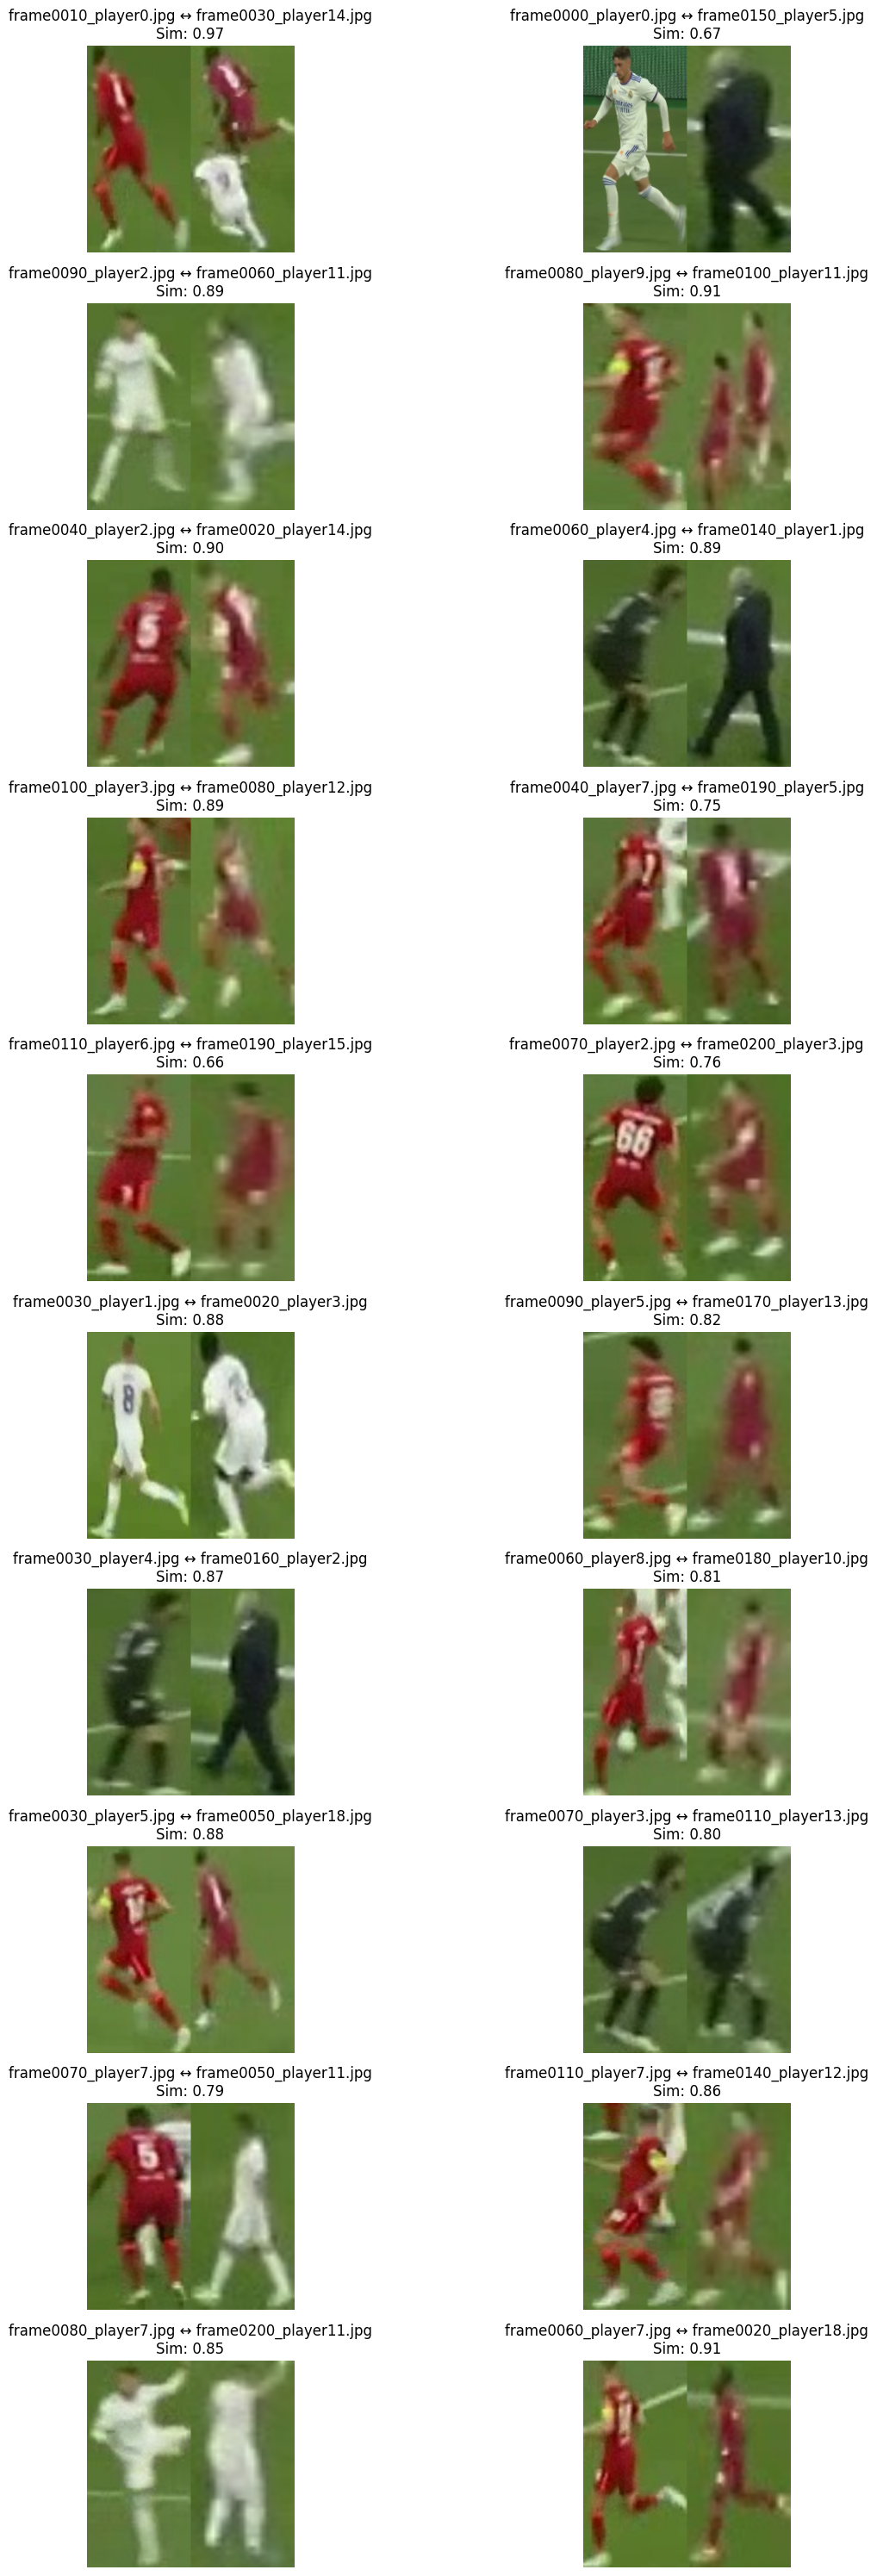

In [13]:
def plot_matches_grid(matches, broadcast_dir, tacticam_dir, max_images=20, cols=2):
    rows = (min(len(matches), max_images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    for idx, (bname, tname, score) in enumerate(matches[:max_images]):
        row, col = divmod(idx, cols)
        ax = axes[row][col] if rows > 1 else axes[col]

        img1 = cv2.imread(str(Path(broadcast_dir) / bname))
        img2 = cv2.imread(str(Path(tacticam_dir) / tname))

        if img1 is None or img2 is None:
            continue

        img1 = cv2.resize(img1, (128, 256))
        img2 = cv2.resize(img2, (128, 256))
        combined = np.hstack((img1, img2))

        ax.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
        ax.set_title(f"{bname} ↔ {tname}\nSim: {score:.2f}")
        ax.axis("off")

    for idx in range(len(matches[:max_images]), rows * cols):
        row, col = divmod(idx, cols)
        ax = axes[row][col] if rows > 1 else axes[col]
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_matches_grid(matches, OUTPUT_DIR / "broadcast", OUTPUT_DIR / "tacticam")


In [11]:
MATCHED_OUTPUT_DIR = Path("output/matched_pairs")
MATCHED_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for bname, tname, score in matches:
    img1 = cv2.imread(str(OUTPUT_DIR / "broadcast" / bname))
    img2 = cv2.imread(str(OUTPUT_DIR / "tacticam" / tname))

    if img1 is None or img2 is None:
        continue

    img1 = cv2.resize(img1, (128, 256))
    img2 = cv2.resize(img2, (128, 256))
    combined = np.hstack((img1, img2))
    out_path = MATCHED_OUTPUT_DIR / f"{bname.split('.')[0]}_{tname.split('.')[0]}.jpg"
    cv2.imwrite(str(out_path), combined)

In [2]:
from google.colab import files
uploaded = files.upload()


Saving broadcast.mp4 to broadcast.mp4
